In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Set seed for reproducibility
random.seed(42)
np.random.seed(42)

# PARAMETERS
NUM_USERS = 1000
NUM_PRODUCTS = 50
NUM_EVENTS = 10000

# DEVICE and LOCATION options
devices = ['mobile', 'desktop', 'tablet']
locations = ['Mumbai', 'Delhi', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai']

# PRODUCT CATEGORIES
categories = ['electronics', 'clothing', 'home', 'books', 'toys']

# 1. USERS TABLE
users = pd.DataFrame({
    'user_id': range(1, NUM_USERS + 1),
    'device': np.random.choice(devices, NUM_USERS),
    'location': np.random.choice(locations, NUM_USERS)
})
users.to_csv("users.csv", index=False)

# 2. PRODUCTS TABLE
products = pd.DataFrame({
    'product_id': range(101, 101 + NUM_PRODUCTS),
    'category': np.random.choice(categories, NUM_PRODUCTS),
    'price': np.random.randint(100, 2000, NUM_PRODUCTS)
})
products.to_csv("products.csv", index=False)

# 3. EVENTS TABLE
event_types = ['view_product', 'add_to_cart', 'checkout', 'purchase']

def simulate_events(num_events):
    events = []
    start_time = datetime(2025, 5, 1)

    for _ in range(num_events):
        user_id = random.randint(1, NUM_USERS)
        product_id = random.randint(101, 100 + NUM_PRODUCTS)

        # Funnel logic (view → cart → checkout → purchase)
        funnel = ['view_product']
        if random.random() < 0.7:
            funnel.append('add_to_cart')
            if random.random() < 0.5:
                funnel.append('checkout')
                if random.random() < 0.4:
                    funnel.append('purchase')

        # Assign timestamps
        time = start_time + timedelta(minutes=random.randint(0, 43200))  # ~30 days
        for event in funnel:
            events.append({
                'user_id': user_id,
                'event_time': time.strftime("%Y-%m-%d %H:%M:%S"),
                'event_type': event,
                'product_id': product_id
            })
            time += timedelta(minutes=random.randint(1, 20))  # Time gap between steps

    return pd.DataFrame(events)

events_df = simulate_events(NUM_EVENTS)
events_df.to_csv("events.csv", index=False)

print("✅ Dataset generated: users.csv, products.csv, events.csv")


✅ Dataset generated: users.csv, products.csv, events.csv


In [ ]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from CSV
users = pd.read_csv("users.csv")
products = pd.read_csv("products.csv")
events = pd.read_csv("events.csv")


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   1000 non-null   int64 
 1   device    1000 non-null   object
 2   location  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [ ]:
# Create an in-memory SQLite database using SQLAlchemy
engine = create_engine('sqlite:///:memory:')

# Write DataFrames into SQL tables
users.to_sql("users", engine, index=False, if_exists="replace")
products.to_sql("products", engine, index=False, if_exists="replace")
events.to_sql("events", engine, index=False, if_exists="replace")


22028

In [ ]:
query = """
SELECT
    event_type,
    COUNT(DISTINCT user_id) AS unique_users
FROM events
GROUP BY event_type
ORDER BY
    CASE event_type
        WHEN 'view_product' THEN 1
        WHEN 'add_to_cart' THEN 2
        WHEN 'checkout' THEN 3
        WHEN 'purchase' THEN 4
    END
"""

funnel_counts = pd.read_sql(query, engine)
print(funnel_counts)


     event_type  unique_users
0  view_product          1000
1   add_to_cart          1000
2      checkout           976
3      purchase           734


In [ ]:
funnel_counts['drop_off'] = funnel_counts['unique_users'].shift(1) - funnel_counts['unique_users']
funnel_counts['drop_off_rate'] = (funnel_counts['drop_off'] / funnel_counts['unique_users'].shift(1)) * 100
funnel_counts = funnel_counts.round(2)

print(funnel_counts)


     event_type  unique_users  drop_off  drop_off_rate
0  view_product          1000       NaN            NaN
1   add_to_cart          1000       0.0            0.0
2      checkout           976      24.0            2.4
3      purchase           734     242.0           24.8


In [ ]:
query_device = """
SELECT
    u.device,
    e.event_type,
    COUNT(DISTINCT e.user_id) AS user_count
FROM events e
JOIN users u ON e.user_id = u.user_id
GROUP BY u.device, e.event_type
ORDER BY u.device,
    CASE e.event_type
        WHEN 'view_product' THEN 1
        WHEN 'add_to_cart' THEN 2
        WHEN 'checkout' THEN 3
        WHEN 'purchase' THEN 4
    END
"""

device_segment = pd.read_sql(query_device, engine)
print(device_segment)


     device    event_type  user_count
0   desktop  view_product         326
1   desktop   add_to_cart         326
2   desktop      checkout         323
3   desktop      purchase         239
4    mobile  view_product         355
5    mobile   add_to_cart         355
6    mobile      checkout         341
7    mobile      purchase         269
8    tablet  view_product         319
9    tablet   add_to_cart         319
10   tablet      checkout         312
11   tablet      purchase         226


In [ ]:
query_category = """
SELECT
    p.category,
    e.event_type,
    COUNT(DISTINCT e.user_id) AS user_count
FROM events e
JOIN products p ON e.product_id = p.product_id
GROUP BY p.category, e.event_type
ORDER BY p.category,
    CASE e.event_type
        WHEN 'view_product' THEN 1
        WHEN 'add_to_cart' THEN 2
        WHEN 'checkout' THEN 3
        WHEN 'purchase' THEN 4
    END
"""

category_segment = pd.read_sql(query_category, engine)
print(category_segment)


       category    event_type  user_count
0         books  view_product         925
1         books   add_to_cart         836
2         books      checkout         605
3         books      purchase         304
4      clothing  view_product         873
5      clothing   add_to_cart         780
6      clothing      checkout         526
7      clothing      purchase         241
8   electronics  view_product         691
9   electronics   add_to_cart         559
10  electronics      checkout         324
11  electronics      purchase         142
12         home  view_product         872
13         home   add_to_cart         778
14         home      checkout         518
15         home      purchase         249
16         toys  view_product         874
17         toys   add_to_cart         758
18         toys      checkout         519
19         toys      purchase         246


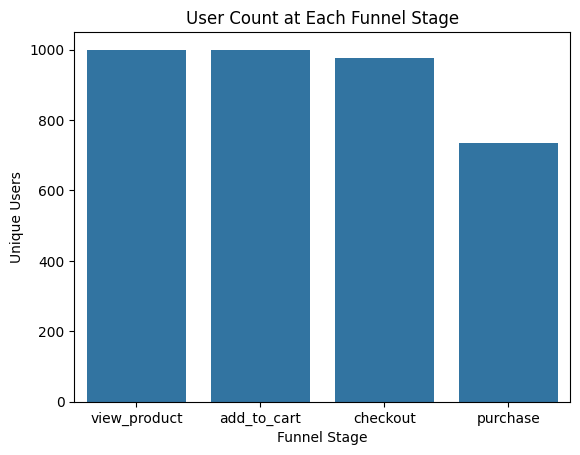

In [ ]:
sns.barplot(data=funnel_counts, x='event_type', y='unique_users')
plt.title("User Count at Each Funnel Stage")
plt.ylabel("Unique Users")
plt.xlabel("Funnel Stage")
plt.show()


In [ ]:
funnel_counts.to_csv("funnel_stage_counts.csv", index=False)
device_segment.to_csv("funnel_by_device.csv", index=False)
category_segment.to_csv("funnel_by_category.csv", index=False)
